In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv("./DATA/train.csv", index_col="Id")
df.shape

(7500, 17)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [5]:
#bring the string columns to one format 
string_cols = list(df.dtypes[df.dtypes == "object"].index)
df[string_cols] = df[string_cols].apply(lambda x: x.str.lower().str.replace(" ", "_"))

In [6]:
(df.isnull().sum() / df.shape[0])*100

home_ownership                   0.000000
annual_income                   20.760000
years_in_current_job             4.946667
tax_liens                        0.000000
number_of_open_accounts          0.000000
years_of_credit_history          0.000000
maximum_open_credit              0.000000
number_of_credit_problems        0.000000
months_since_last_delinquent    54.413333
bankruptcies                     0.186667
purpose                          0.000000
term                             0.000000
current_loan_amount              0.000000
current_credit_balance           0.000000
monthly_debt                     0.000000
credit_score                    20.760000
credit_default                   0.000000
dtype: float64

In [7]:
#what is I do away with the month since last deliquent 
df.drop("months_since_last_delinquent", axis=1, inplace=True)

In [8]:
df.shape

(7500, 16)

In [9]:
bank = {
    0.0:"zero",
    1.0:"one", 
    2.0:"two",
    3.0:"three",
    4.0:"four"
}

tax = {
    0.0:"zero",
    1.0:"one", 
    2.0:"two",
    3.0:"three",
    4.0:"four",
    5.0:"five",
    6.0:"six", 
    7.0:"seven"
}
    
cred_problems = {
    0.0:"zero",
    1.0:"one", 
    2.0:"two",
    3.0:"three",
    4.0:"four",
    5.0:"five",
    6.0:"six", 
    7.0:"seven"
}

maps = [bank, tax, cred_problems]

In [10]:
for i, col in enumerate(["bankruptcies","tax_liens","number_of_credit_problems"]):
    df[col] = df[col].map(maps[i])


In [11]:
numerical_cols = list(df.dtypes[df.dtypes !="object"].index)
categorical_cols = list(df.dtypes[df.dtypes == "object"].index)
numerical_cols.remove("credit_default")

In [12]:
df_ = df.copy()

In [13]:
#impute missing values in the following columns 
for col in ["annual_income", "credit_score"]:
    df_[col] = df_[col].fillna(0)

In [14]:
#drop the rows with null values for the years_in_current_job column
df_.dropna(subset=["years_in_current_job","bankruptcies"], inplace=True)

In [15]:
df_.drop_duplicates()
df_.shape

(7115, 16)

In [16]:
#copy the dataframe before making further changes 
all_df = df_.copy()

# EDA

In [17]:
import seaborn as sns

<AxesSubplot: >

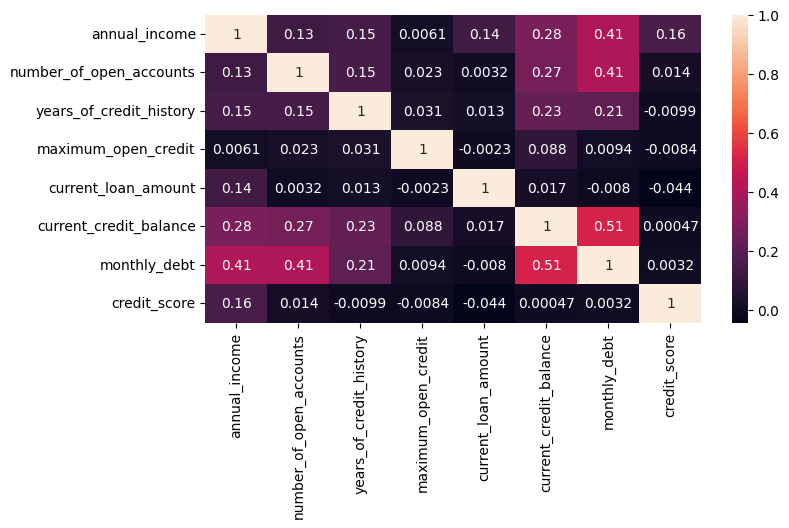

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(all_df[numerical_cols].corr(), annot=True,ax=ax)

### Global and Group rates
Global credit default rate - the likelihoood of a custome to default. From the result below, there is a 27.7% chance that a customer will default.
Group credit default rate - the likelihood that a custome from a particular group is going to churn. If this value is nearly or equal to the global group  rate(the difference between the global and groups rates is small), then this group is not very important when predicting credit default as it is not any different from the other groups.
On the other hand if the difference is large, there is something about the group that sets it apart from the rest making it important when predicting credit default.

### Risk ratio 
Risk - Risk of an effect. How likely the customers of a group are to have an efect (default) compared to customers from the entire dataset.
=group_rate / global rate.

if risk == 1 - means not risky at all. Customers from this group are as likely to default as any other customer from the entire dataset

if risk < 1 - Customers from this group are less likely to default

if risk > 1 - Risky - Customers from this group are more likely to default.


In [19]:
global_default_rate = all_df.credit_default.mean()
print("%.4f"%global_default_rate)

0.2772


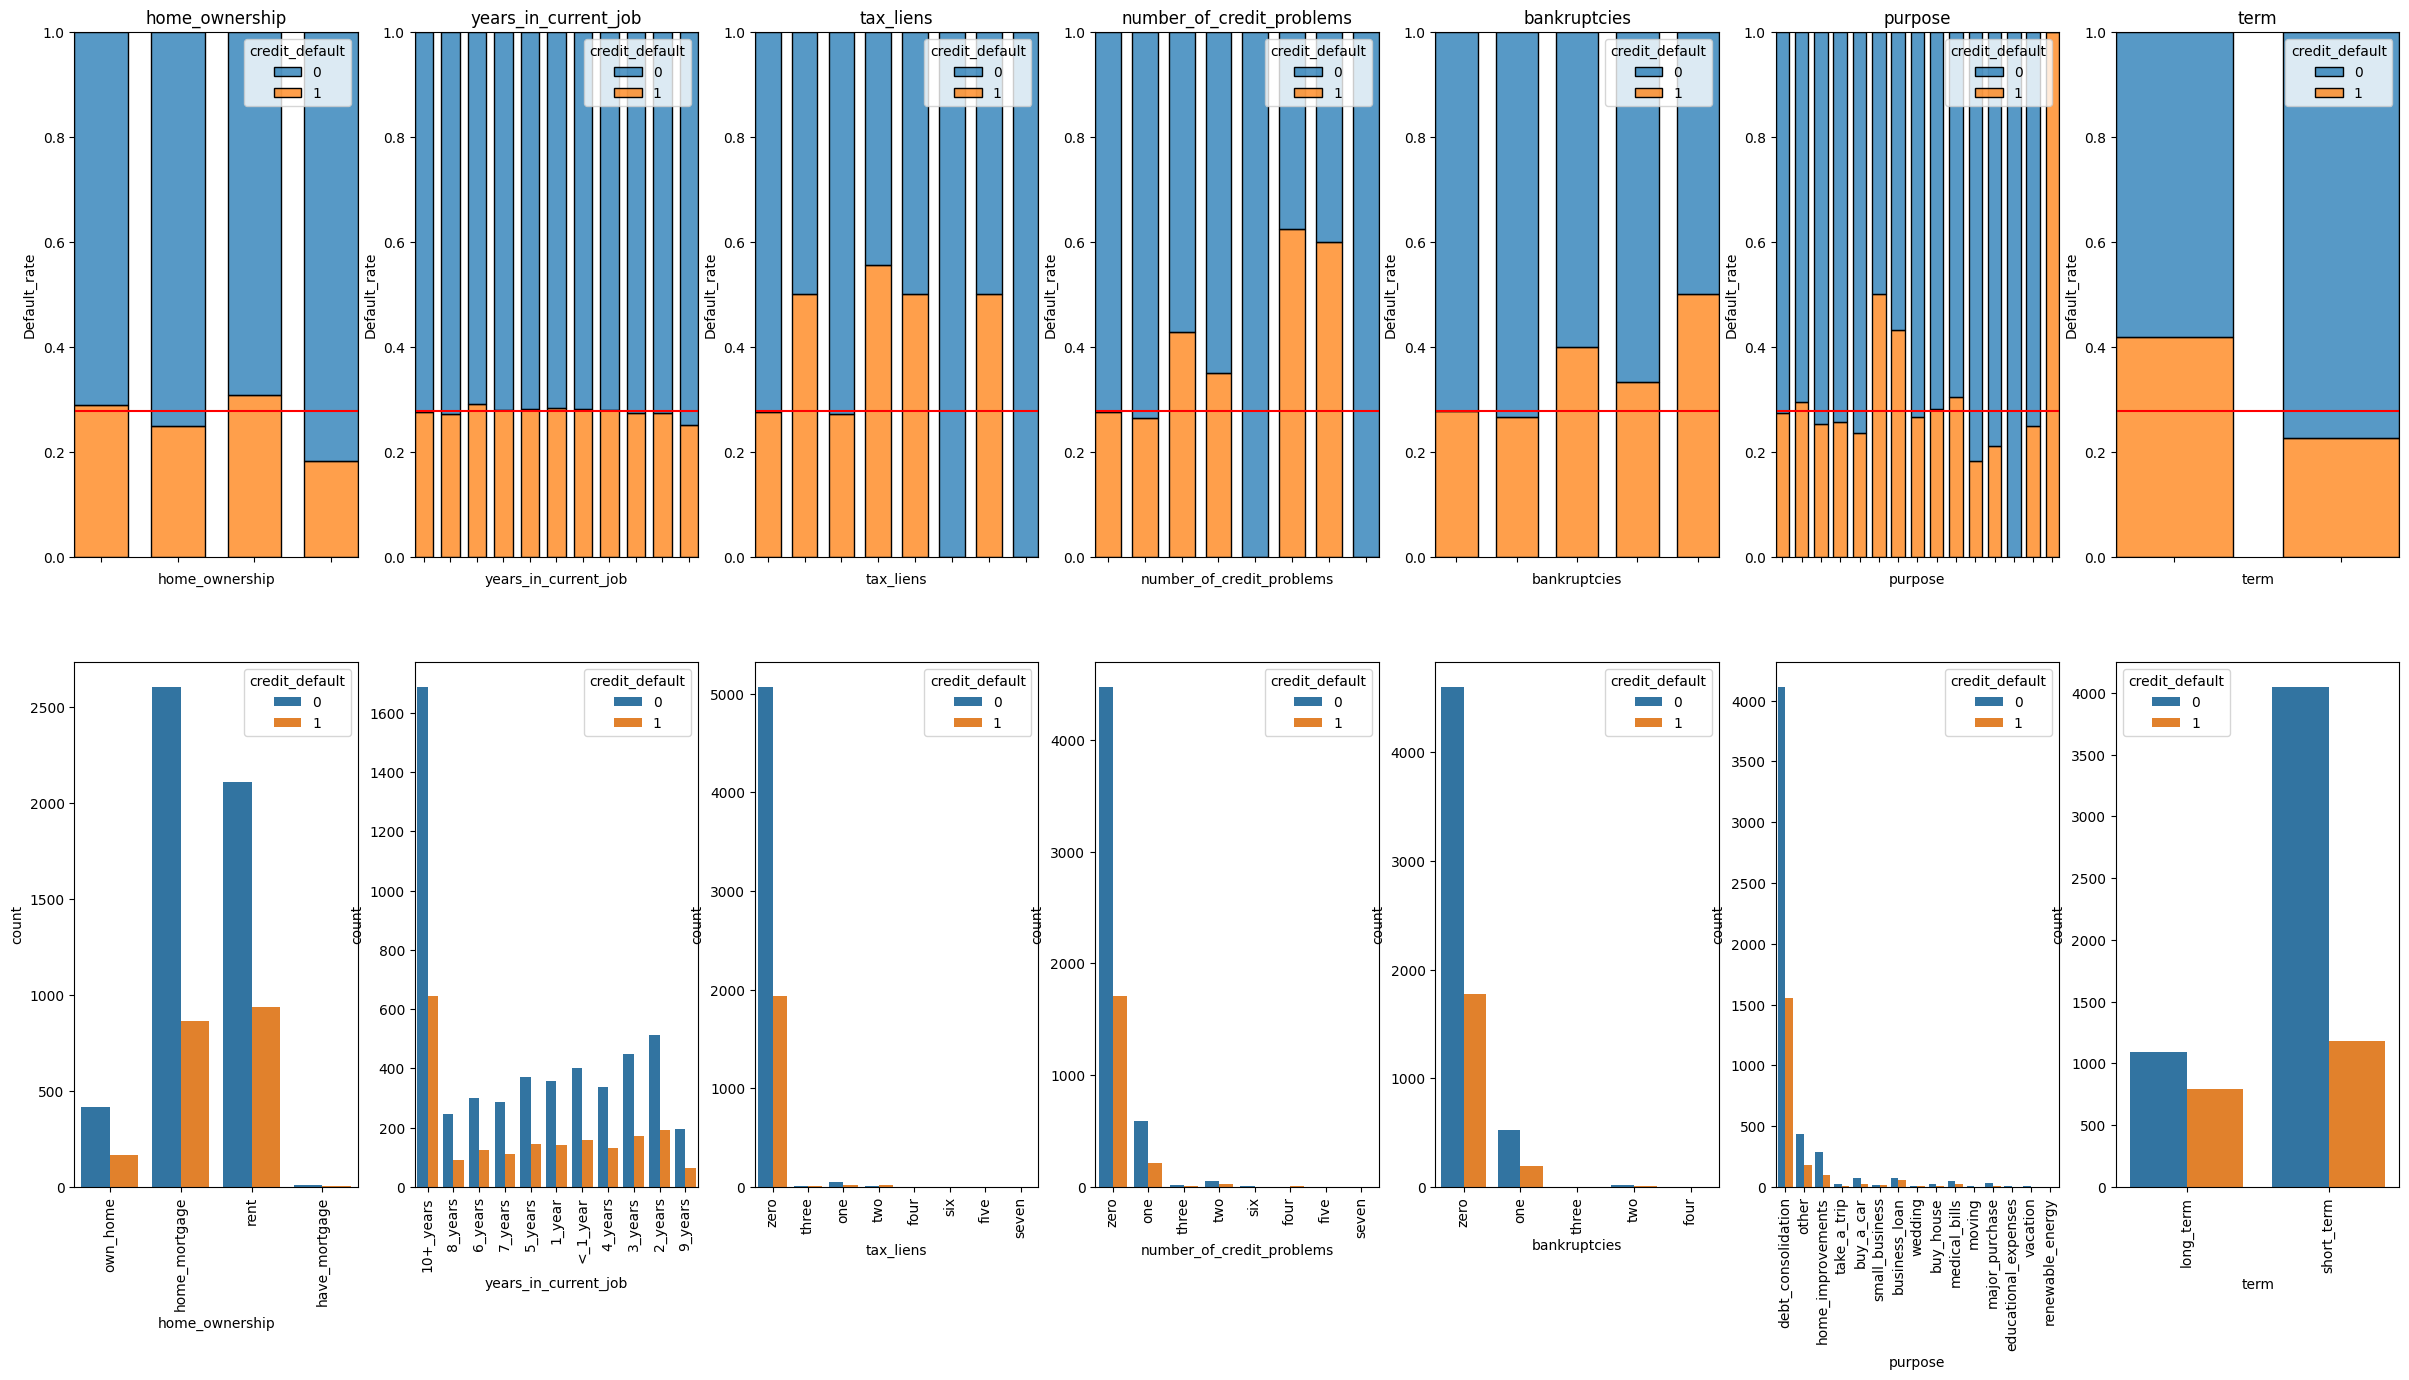

In [20]:
fig, ax=plt.subplots(2, len(categorical_cols), figsize=(30,15))

for i, col in enumerate(categorical_cols):
    sns.histplot(all_df, hue="credit_default",x=col, shrink=.7, multiple="fill", ax=ax[0][i])
    sns.countplot(all_df, hue="credit_default", x=col, ax=ax[1][i])
    ax[0][i].axhline(y=0.2772, color="red")
    ax[0][i].set_title(f"{col}")
    ax[0][i].set_ylabel("Default_rate")
    ax[0][i].set_xticklabels((), rotation=90)
    ax[1][i].set_xticklabels(ax[1][i].get_xticklabels(), rotation=90)

years_in_current_job -  is not a good predictor of credit_default. All the groups in this category have nearly equaly credit_default rate.

number_of_credit_problems - groups two, three, four and five have credit default rates way above the global credit default rate. They are however under-represented and hence might not be very important to the machine learning model.

The same goes for bankruptcies, purpose and tax_liens.

Customers who take loans for long term have higher risk for churning.



In [21]:
from IPython.display import display
for col in categorical_cols:
    df_group = all_df.groupby(by=col).credit_default.agg(['mean'])
    df_group["diff"] = df_group["mean"] - global_default_rate
    df_group["risk"] = df_group["mean"] / global_default_rate
    display(df_group)

,mean,diff,risk
home_ownership,,,
have_mortgage,0.181818,-0.095343,0.656002
home_mortgage,0.248703,-0.028458,0.897324
own_home,0.288660,0.011499,1.041488
rent,0.307667,0.030506,1.110067


,mean,diff,risk
years_in_current_job,,,
10+_years,0.275847,-0.001314,0.995260
1_year,0.283433,0.006272,1.022630
2_years,0.273115,-0.004046,0.985403
3_years,0.274194,-0.002967,0.989294
4_years,0.279318,0.002157,1.007782
5_years,0.281008,0.003847,1.013879
6_years,0.291765,0.014604,1.052691
7_years,0.280303,0.003142,1.011337
8_years,0.272189,-0.004972,0.982062


,mean,diff,risk
tax_liens,,,
five,0.500000,0.222839,1.804006
four,0.500000,0.222839,1.804006
one,0.271429,-0.005732,0.979318
seven,0.000000,-0.277161,0.000000
six,0.000000,-0.277161,0.000000
three,0.500000,0.222839,1.804006
two,0.555556,0.278395,2.004451
zero,0.275754,-0.001407,0.994923


,mean,diff,risk
number_of_credit_problems,,,
five,0.600000,0.322839,2.164807
four,0.625000,0.347839,2.255008
one,0.265000,-0.012161,0.956123
seven,0.000000,-0.277161,0.000000
six,0.000000,-0.277161,0.000000
three,0.428571,0.151411,1.546291
two,0.349398,0.072237,1.260631
zero,0.276592,-0.000569,0.997948


,mean,diff,risk
bankruptcies,,,
four,0.500000,0.222839,1.804006
one,0.266949,-0.010212,0.963156
three,0.400000,0.122839,1.443205
two,0.333333,0.056172,1.202671
zero,0.277891,0.000730,1.002634


,mean,diff,risk
purpose,,,
business_loan,0.432000,0.154839,1.558661
buy_a_car,0.236559,-0.040602,0.853508
buy_house,0.281250,0.004089,1.014753
debt_consolidation,0.273658,-0.003503,0.987362
educational_expenses,0.000000,-0.277161,0.000000
home_improvements,0.253927,-0.023234,0.916171
major_purchase,0.210526,-0.066635,0.759582
medical_bills,0.304348,0.027187,1.098091
moving,0.181818,-0.095343,0.656002


,mean,diff,risk
term,,,
long_term,0.418790,0.141629,1.510999
short_term,0.226152,-0.051009,0.815958


### Mutual Information
Measure of mutual dependancy between the features and the target. The higher the value the more useful the feature is at predicting the target.

In [22]:
from sklearn.metrics import mutual_info_score

def MI(series):
    return mutual_info_score(series, all_df.credit_default)

df_mi = all_df[categorical_cols].apply(MI)
df_mi.sort_values(ascending=False).to_frame(name="Mutual_information")

,Mutual_information
term,0.017189
purpose,0.002315
home_ownership,0.002048
number_of_credit_problems,0.001076
tax_liens,0.001037
years_in_current_job,0.000121
bankruptcies,0.000112


### Correlation coefficient

In [23]:
all_df[numerical_cols].corrwith(all_df.credit_default).sort_values(ascending=False)

credit_score               0.351267
number_of_open_accounts    0.034825
monthly_debt               0.023495
current_credit_balance    -0.013407
maximum_open_credit       -0.014022
years_of_credit_history   -0.030081
annual_income             -0.105684
current_loan_amount       -0.224017
dtype: float64

In [24]:
cols_to_remove = ["years_in_current_job","tax_liens","purpose","bankruptcies","number_of_credit_problems"]
all_df.drop(columns=cols_to_remove, axis=1, inplace=True)

for col in cols_to_remove:
    categorical_cols.remove(col)


In [25]:
all_df.columns

Index(['home_ownership', 'annual_income', 'number_of_open_accounts',
       'years_of_credit_history', 'maximum_open_credit', 'term',
       'current_loan_amount', 'current_credit_balance', 'monthly_debt',
       'credit_score', 'credit_default'],
      dtype='object')

### Build  Model

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

In [44]:
dv = DictVectorizer(sparse=False)
cat_dict = all_df[categorical_cols].to_dict(orient="records")
encoded_cat_cols = dv.fit_transform(cat_dict)

In [45]:
stacked = np.hstack((all_df[numerical_cols].values, encoded_cat_cols))
new_df = pd.DataFrame(data=stacked, columns=numerical_cols+dv.feature_names_)

In [46]:
new_df.head(2).T

,0,1
annual_income,1025487.0,751412.0
number_of_open_accounts,15.0,11.0
years_of_credit_history,15.3,35.0
maximum_open_credit,1181730.0,1182434.0
current_loan_amount,264968.0,99999999.0
current_credit_balance,394972.0,308389.0
monthly_debt,18373.0,13651.0
credit_score,737.0,742.0
home_ownership=have_mortgage,0.0,0.0
home_ownership=home_mortgage,0.0,1.0


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import  f1_score, recall_score

In [31]:
#split the data into test train and validation sets 
y = all_df.credit_default.values
df_train_full, df_val, y_train_full, y_val = train_test_split(new_df, y, test_size=0.2, random_state=42)
df_train, df_test, y_train, y_test = train_test_split(df_train_full,y_train_full, test_size=0.2, random_state=42) 

In [48]:
#perform scaling on the numerical cols
scaled_df_train = df_train.copy()
scaled_df_val = df_val.copy()
scaler = StandardScaler()
scaled_df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
scaled_df_val[numerical_cols] = scaler.transform(df_val[numerical_cols])

In [49]:
list_of_models = {
    "logistic_reg": LogisticRegression(random_state=42, max_iter=10000),
    "decision_tree": DecisionTreeClassifier(max_depth=5,min_samples_leaf=10,random_state=42),
    "random_forest": RandomForestClassifier(n_estimators=30, max_depth=5,min_samples_leaf=10, random_state=42),
    'GBDT' : GradientBoostingClassifier(n_estimators = 30, max_depth = 5, random_state = 42),
}


In [50]:
def train(models, df_train,df_val, y_train, y_val):
    X_train, X_val = df_train.values, df_val.values
    #f1_train_scores = []
    #f1_val_scores = []
    #recall_test_scores = []

    model_names = models.keys()
    print("model_names\tf1_tain\tf1_val\trecall")
    for model in model_names:
        #train a model
        models[model].fit(X_train, y_train)
        y_train_pred = models[model].predict(X_train)
        y_val_pred = models[model].predict(X_val)
        

        f1_train = f1_score(y_train, y_train_pred, average="macro")
        f1_val = f1_score(y_val, y_val_pred, average="macro")
        recall_val = recall_score(y_val, y_val_pred, average="macro")

        #f1_train = f1_score(y_train, y_train_pred)
        #f1_val = f1_score(y_val, y_val_pred)
        print(f"{model} \t {f1_train:.3f} \t {f1_val:.3f} \t {recall_val:.3f}")
        #print(f"{model}\t{f1_train:.3f}\t\t{f1_val:.3f}")



In [51]:
#performance on non scaled dataset
train(list_of_models,df_train,df_val,y_train, y_val)

model_names	f1_tain	f1_val	recall
logistic_reg 	 0.595 	 0.578 	 0.583
decision_tree 	 0.660 	 0.633 	 0.620
random_forest 	 0.627 	 0.599 	 0.597
GBDT 	 0.671 	 0.632 	 0.620


In [52]:
#performance on scaled dataset
train(list_of_models,scaled_df_train,scaled_df_val,y_train, y_val)

model_names	f1_tain	f1_val	recall
logistic_reg 	 0.643 	 0.629 	 0.617
decision_tree 	 0.660 	 0.633 	 0.620
random_forest 	 0.627 	 0.599 	 0.597
GBDT 	 0.671 	 0.632 	 0.620


logistic regression - performs  better on the scaled dataset.

### FEATURE IMPORTANCE
Permutation feature importance

In [118]:
from sklearn.inspection import permutation_importance

In [119]:
def permutation(models,df_train, df_val, y_train, y_val):
    X_train = df_train.values
    X_val = df_val.values

    train_permutation = {}
    val_permutation = {}

    for model in models.keys():
        train_permutation[model] = permutation_importance(models[model],X_train, y_train,scoring="f1", n_repeats=5, random_state=42, n_jobs=2)
        val_permutation[model] = permutation_importance(models[model],X_val, y_val,scoring="f1", n_repeats=5, random_state=42, n_jobs=2)

   
    train_imp_df = pd.DataFrame({"features":df_train.columns})
    val_imp_df = pd.DataFrame({"features":df_val.columns})
    
    for model in models.keys():
        train_imp_df[f"{model}_imp_mean"] = train_permutation[model].importances_mean
        val_imp_df[f"{model}_imp_mean"] = val_permutation[model].importances_mean
            
    return train_imp_df, val_imp_df

In [120]:
train_imp, val_imp = permutation(list_of_models, scaled_df_train, scaled_df_val, y_train, y_val)

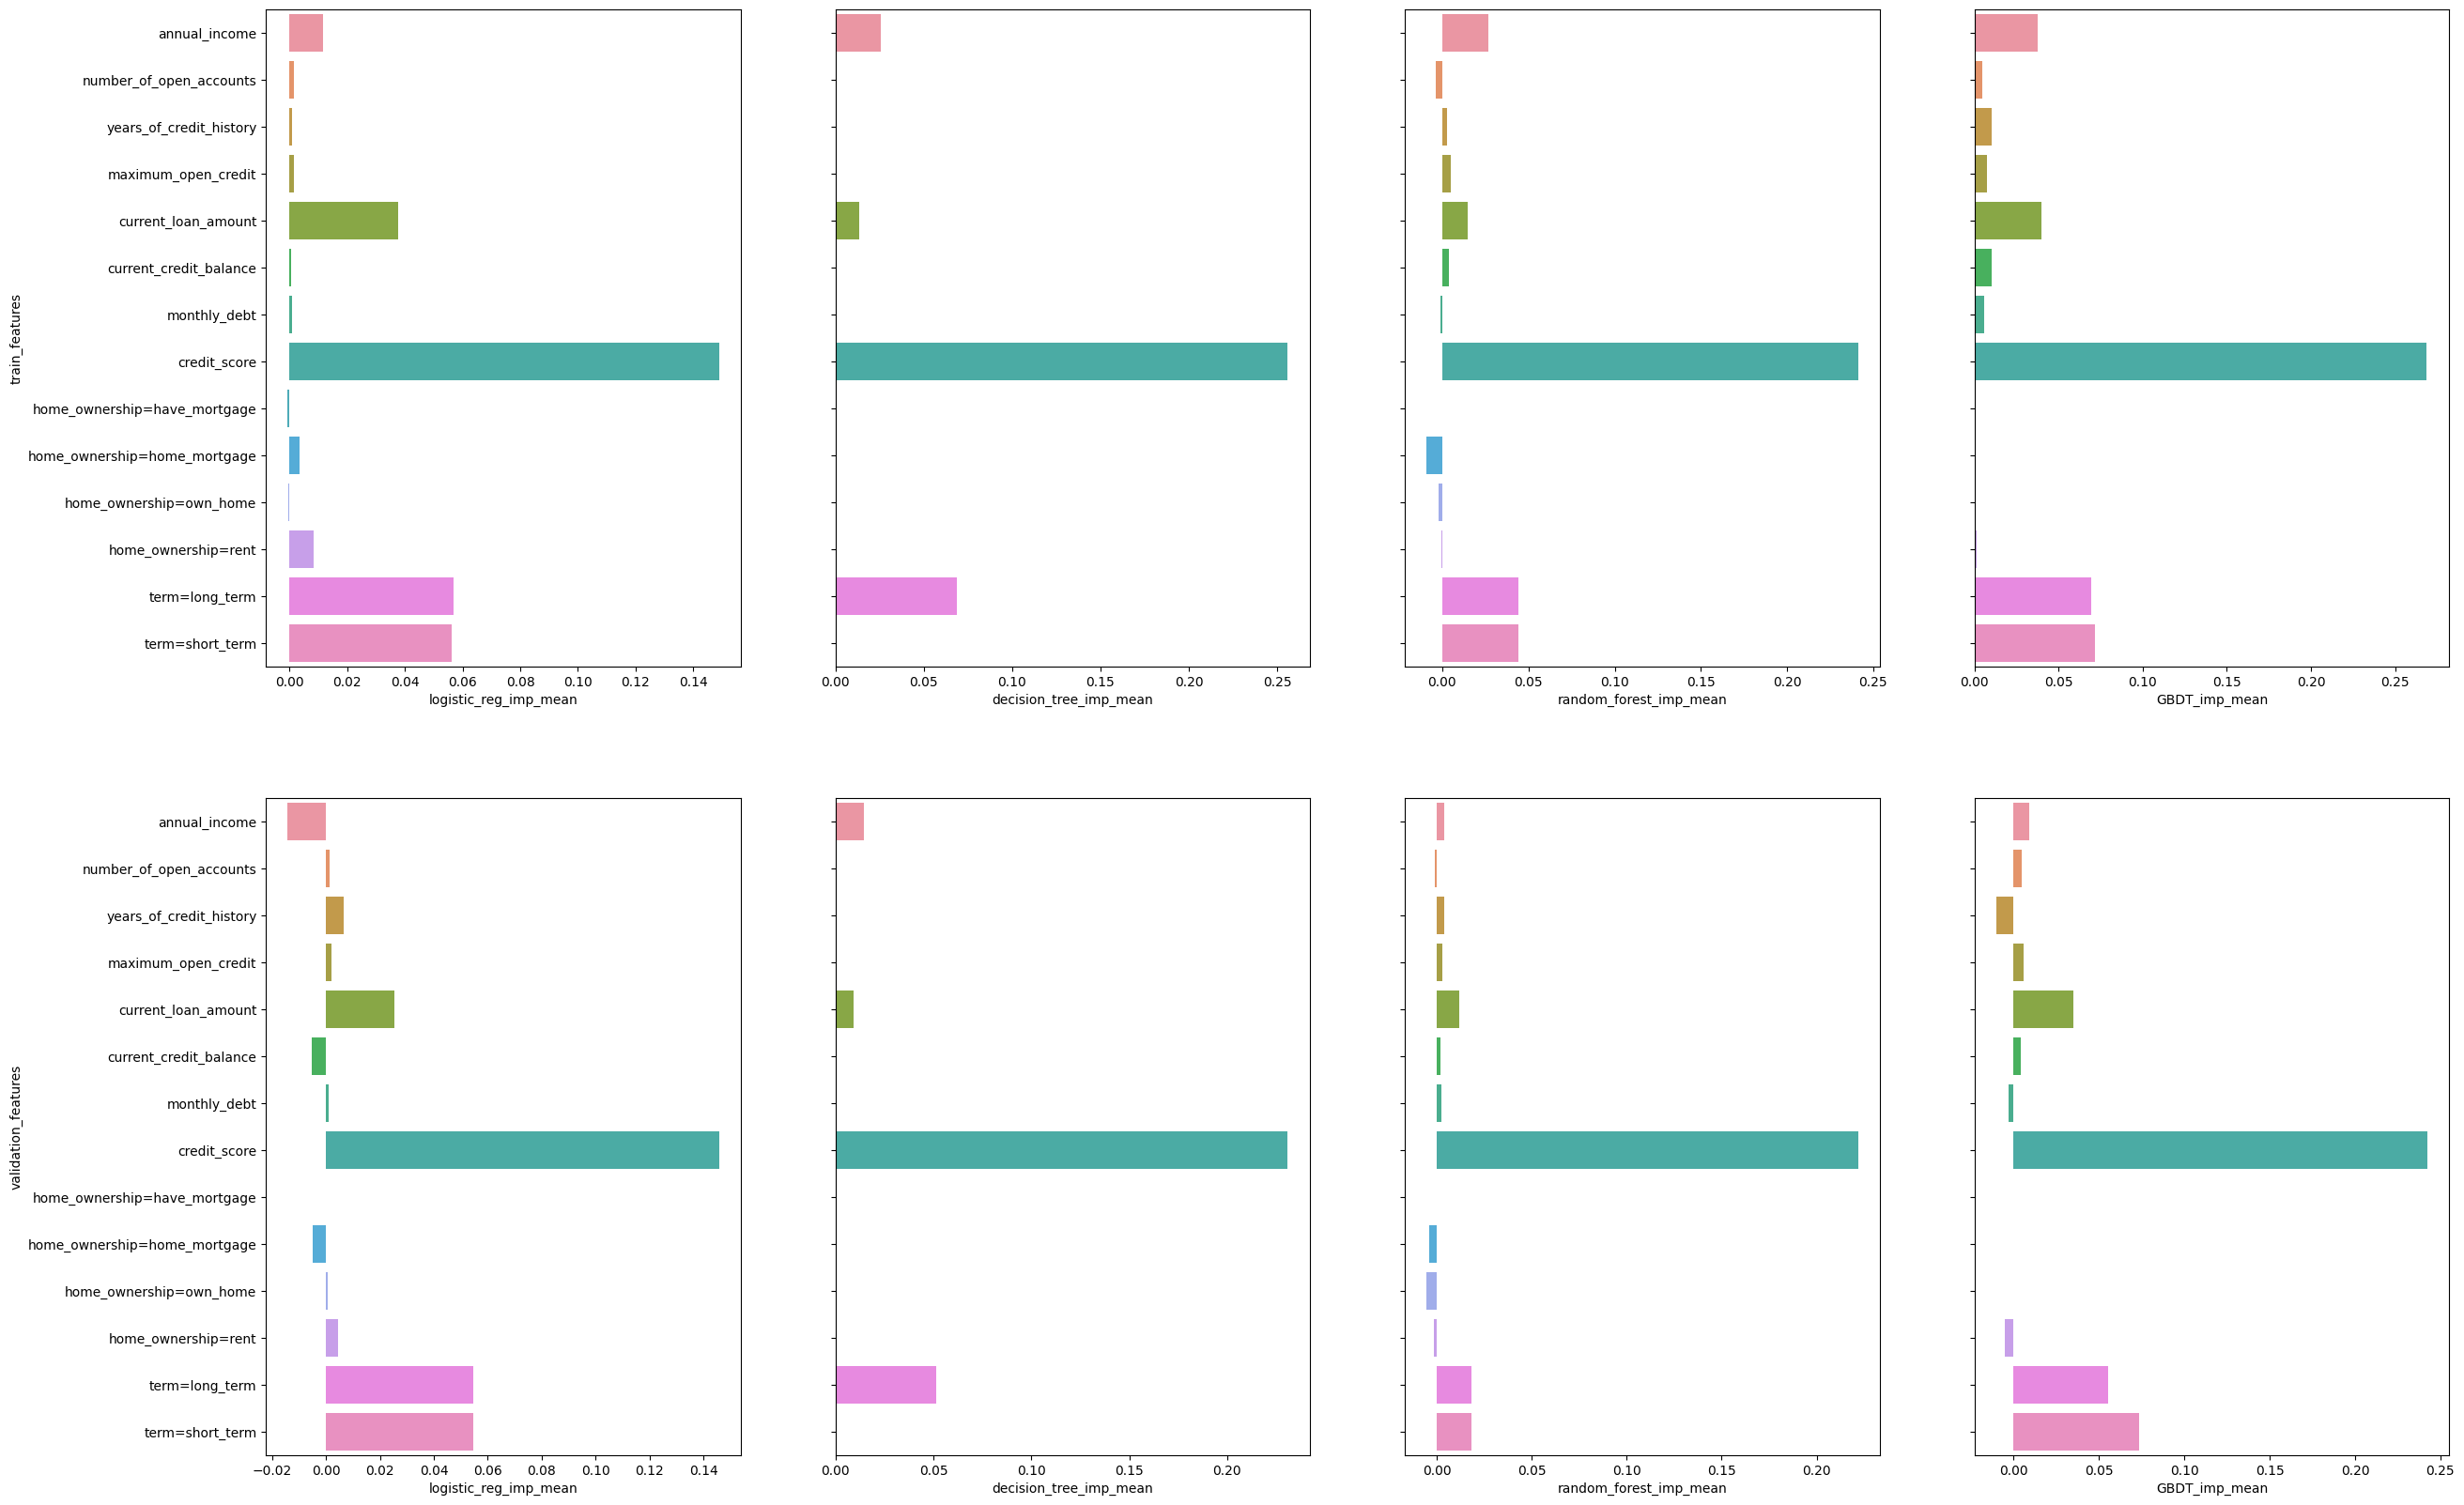

In [121]:
fig, ax = plt.subplots(2,4,figsize=(30,20))
for i,col in enumerate(val_imp.columns[1:]):
    sns.barplot(x=col, y="features", data=train_imp,label=col, ax=ax[0][i])
    sns.barplot(x=col, y="features", data=val_imp,label=col, ax=ax[1][i])
    if i>0:
        ax[0][i].set_yticklabels(())
        ax[0][i].set_ylabel("")
        ax[1][i].set_yticklabels(())
        ax[1][i].set_ylabel("")
    else:
        ax[0][i].set_ylabel("train_features")
        ax[1][i].set_ylabel("validation_features")



Term is the categorical feature that seem to be very important across the four models 

credit_score and current_loan_amount are the most important features (highest score across all the four models)

annual income aslo show significant importance 

In [122]:
def validation_train(df, y, c=None):
    scaler = StandardScaler()
    train_df_copy = df.copy()
    train_df_copy[numerical_cols] = scaler.fit_transform(train_df_copy[numerical_cols])
    
    if c:
        model = LogisticRegression(C=c,random_state=42, max_iter=1000)
    else:
        model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(train_df_copy, y)

    return scaler, model

def predict(df,scaler, model):
    val_df_copy = df.copy()
    val_df_copy[numerical_cols] = scaler.transform(val_df_copy[numerical_cols])
    y_pred = model.predict(val_df_copy)

    return y_pred

In [123]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kf.split(new_df):
    df_train = new_df.iloc[train_idx]
    df_val = new_df.iloc[val_idx]

    y_train = y[train_idx]
    y_val = y[val_idx]

    scaler, model = validation_train(df_train, y_train)
    y_pred = predict(df_val,scaler, model)

    aucs.append(f1_score(y_val, y_pred,average="macro"))

print(f"mean f1:{np.mean(aucs):.3f} std:{np.std(aucs):.3f}")


mean f1:0.636 std:0.014


### Parameter Tunning

In [124]:
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=1)

for c in [0.0001,0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs_ = []
    for train_idx, val_idx in kf.split(new_df):
        df_train = new_df.iloc[train_idx]
        df_val = new_df.iloc[val_idx]

        y_train = y[train_idx]
        y_val = y[val_idx]

        scaler, model = validation_train(df_train, y_train,c=c)
        y_pred = predict(df_val,scaler, model)

        aucs_.append(f1_score(y_val, y_pred,average="macro"))

    print(f"C:{c} mean f1:{np.mean(aucs_):.3f} std:{np.std(aucs_):.4f}")

C:0.0001 mean f1:0.420 std:0.0013
C:0.001 mean f1:0.593 std:0.0150
C:0.01 mean f1:0.602 std:0.0146
C:0.1 mean f1:0.631 std:0.0147
C:0.5 mean f1:0.635 std:0.0158
C:1 mean f1:0.636 std:0.0143
C:10 mean f1:0.640 std:0.0131


### Decision Tree
Parameter tuning for;

1. Maximum depth 

2. leaf size

##### Maximum depth

In [125]:
train_dt_f1_scores = []
val_dt_f1_scores = []
depths = range(0,51,2)
for depth in depths:
    #depth can not be zero
    if depth==0:
        depth+=1
    dt_1 = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_1.fit(df_train.values, y_train)
    y_pred_train = dt_1.predict(df_train.values)
    y_pred_val = dt_1.predict(df_val.values)
    train_dt_f1_scores.append(f1_score(y_pred_train, y_train,average="macro"))
    val_dt_f1_scores.append(f1_score(y_pred_val, y_val,average="macro"))


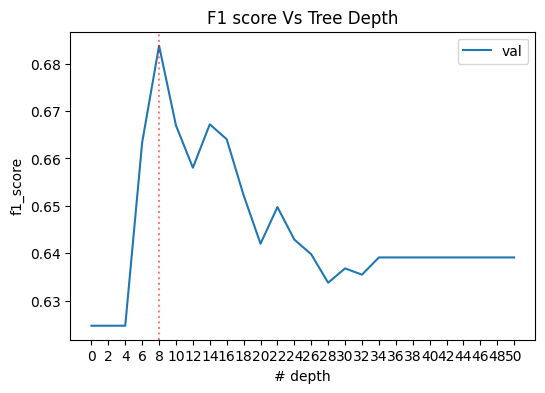

In [126]:
plt.figure(figsize=(6,4))
#plt.plot(depths, train_dt_f1_scores, label="train")
plt.plot(depths, val_dt_f1_scores, label="val")
plt.axvline(x=depths[np.argmax(val_dt_f1_scores)], color="red", linestyle="dotted",alpha=.5)
plt.xticks(depths)
plt.title("F1 score Vs Tree Depth")
plt.ylabel("f1_score")
plt.xlabel("# depth")
plt.legend()

leaf size

In [127]:
train_leaf_scores = []
val_leaf_scores = []
leaf_sizes = range(0,201,2)
for leaf in leaf_sizes:
    #depth can not be zero
    if leaf==0:
        leaf+=1
    dt_1 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=leaf, random_state=42)
    dt_1.fit(df_train.values, y_train)
    y_pred_train = dt_1.predict(df_train.values)
    y_pred_val = dt_1.predict(df_val.values)
    train_leaf_scores.append(f1_score(y_pred_train, y_train,average="macro"))
    val_leaf_scores.append(f1_score(y_pred_val, y_val,average="macro"))

print(f"best performing at {leaf_sizes[np.argmax(val_leaf_scores)]}")

best performing at 14


Text(0.5, 0, '# min_samples_leaf')

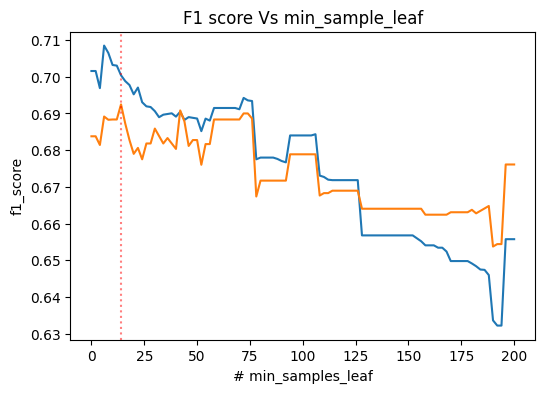

In [128]:
plt.figure(figsize=(6,4))
plt.plot(leaf_sizes, train_leaf_scores, label="train")
plt.plot(leaf_sizes, val_leaf_scores, label="val")
plt.axvline(x=leaf_sizes[np.argmax(val_leaf_scores)], color="red", linestyle="dotted",alpha=.5)
plt.title("F1 score Vs min_sample_leaf")
plt.ylabel("f1_score")
plt.xlabel("# min_samples_leaf")

### Choosing the best threshold 

In [129]:
def thresholding(y_val, y_pred):
    thresholds = np.linspace(0, 1,101)
    scores = []

    for t in thresholds:
        tp = ((y_val==1) & (y_pred>=t)).sum()
        fp = ((y_val==0) & (y_pred>=t)).sum()
        tn = ((y_val==0) & (y_pred<t)).sum()
        fn = ((y_val==1) & (y_pred<t)).sum()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn) #aka true positive rate
        fpr = fp/(fp+tn)
        f1 = 2*precision*recall/(precision+recall)
        acc  = (tp+tn)/(tp+tn+fp+fn)

        scores.append((t,tp,fp,tn,fn,precision, recall, fpr, f1, acc))
    
    columns = ["t","tp","fp","tn","fn","precision","recall/tpr","fpr","f1","accuracy"]
    scores_df = pd.DataFrame(data=scores,columns=columns)

    return scores_df

In [137]:
final_scaler = StandardScaler()
scaled_df = new_df.copy()
scaled_test = df_test.copy()
scaled_df[numerical_cols]= final_scaler.fit_transform(new_df[numerical_cols])
scaled_test[numerical_cols] = final_scaler.transform(df_test[numerical_cols])

In [155]:
#train the dt on the entire dataset 
final_dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=14,random_state=42)
final_dt.fit(scaled_df, y)
y_test_pred = final_dt.predict(scaled_test)
f1_score(y_test_pred, y_test,average="macro")

0.6823259339779164

In [156]:
y_test_pred = final_dt.predict_proba(scaled_test)[:,1]
dt_threshold_df = thresholding(y_test, y_test_pred)
dt_threshold_df[dt_threshold_df.f1==dt_threshold_df.f1.max()]
#dt_threshold_df[::2]

,t,tp,fp,tn,fn,precision,recall/tpr,fpr,f1,accuracy
28,0.28,174,114,703,148,0.604167,0.540373,0.139535,0.570492,0.769974
29,0.29,174,114,703,148,0.604167,0.540373,0.139535,0.570492,0.769974
30,0.30,174,114,703,148,0.604167,0.540373,0.139535,0.570492,0.769974
31,0.31,174,114,703,148,0.604167,0.540373,0.139535,0.570492,0.769974
32,0.32,174,114,703,148,0.604167,0.540373,0.139535,0.570492,0.769974


In [157]:
final_logistic_reg = LogisticRegression(max_iter=1000, C=0.5,random_state=42)
final_logistic_reg.fit(scaled_df, y)
y_pred = final_logistic_reg.predict_proba(scaled_test)[:,1]

In [158]:
logit_threshold_df = thresholding(y_test, y_pred)
logit_threshold_df[logit_threshold_df.f1 == logit_threshold_df.f1.max()]

,t,tp,fp,tn,fn,precision,recall/tpr,fpr,f1,accuracy
25,0.25,249,321,496,73,0.436842,0.773292,0.392901,0.558296,0.654083


In [205]:
testing_df = pd.read_csv("./DATA/test.csv", index_col="Id")
indices = testing_df.index
testing_df.shape

(2500, 16)

In [206]:
testing_df.columns = testing_df.columns.str.lower().str.replace(" ","_")

In [207]:
testing_df.columns

Index(['home_ownership', 'annual_income', 'years_in_current_job', 'tax_liens',
       'number_of_open_accounts', 'years_of_credit_history',
       'maximum_open_credit', 'number_of_credit_problems',
       'months_since_last_delinquent', 'bankruptcies', 'purpose', 'term',
       'current_loan_amount', 'current_credit_balance', 'monthly_debt',
       'credit_score'],
      dtype='object')

In [208]:
cols_to_remove = ['months_since_last_delinquent',"years_in_current_job","tax_liens","purpose","bankruptcies","number_of_credit_problems"]
testing_df.drop(columns=cols_to_remove, axis=1, inplace=True)

In [209]:
testing_df.isnull().sum()

home_ownership               0
annual_income              513
number_of_open_accounts      0
years_of_credit_history      0
maximum_open_credit          0
term                         0
current_loan_amount          0
current_credit_balance       0
monthly_debt                 0
credit_score               513
dtype: int64

In [210]:
for col in ["annual_income", "credit_score"]:
    testing_df[col] = testing_df[col].fillna(0)

In [211]:
testing_cat_cols = list(testing_df.dtypes[testing_df.dtypes == "object"].index)
testing_num_cols = list(testing_df.dtypes[testing_df.dtypes !=object].index)

In [212]:
testing_num_cols

['annual_income',
 'number_of_open_accounts',
 'years_of_credit_history',
 'maximum_open_credit',
 'current_loan_amount',
 'current_credit_balance',
 'monthly_debt',
 'credit_score']

In [213]:
testing_dv = DictVectorizer(sparse=False)
testing_dict = testing_df[categorical_cols].to_dict(orient="records")
testing_encoded = testing_dv.fit_transform(testing_dict)
full_testing = np.hstack((final_scaler.transform(testing_df[testing_num_cols]), testing_encoded))
testing_df = pd.DataFrame(data=full_testing, columns=testing_num_cols+testing_dv.feature_names_)

In [223]:
pred = final_dt.predict_proba(testing_df)[:,1]>=0.32
pred = pred.astype(int)
pred.mean() #how many are predicted as credit_default

0.2384

In [226]:
submission_df = pd.DataFrame(data=pred, index=indices, columns=["Credit Default"])

In [228]:
submission_df.to_csv("submission.csv")